<a href="https://colab.research.google.com/github/Geeth-2905/Fake-Job-Posting-Detection-Using-AI/blob/main/Fake_Job_Posting_Detection_using_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please upload the TRAINING dataset (must include: 'description' and 'fraudulent' columns):


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Saving balanced_jobs.csv to balanced_jobs.csv


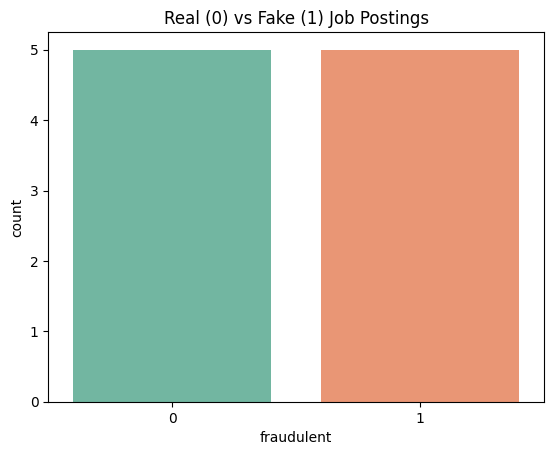

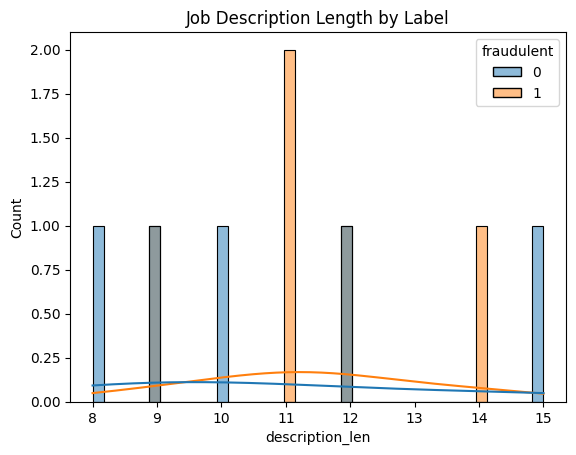

Logistic Regression Accuracy: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



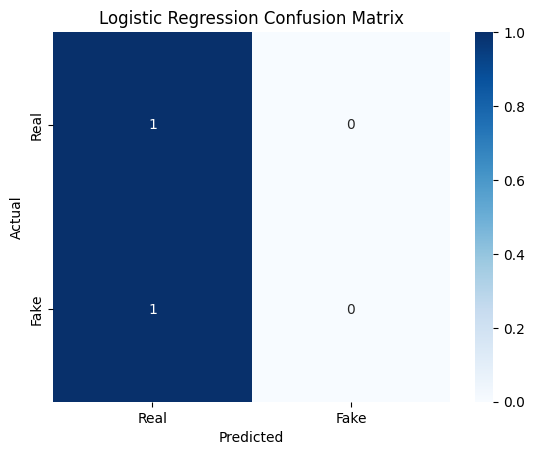

Epoch 1/4
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.5714 - loss: 0.6859 - val_accuracy: 0.0000e+00 - val_loss: 0.7215
Epoch 2/4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.5714 - loss: 0.6954 - val_accuracy: 0.0000e+00 - val_loss: 0.7334
Epoch 3/4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.5714 - loss: 0.6761 - val_accuracy: 0.0000e+00 - val_loss: 0.7448
Epoch 4/4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.5714 - loss: 0.6786 - val_accuracy: 0.0000e+00 - val_loss: 0.7535
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5000 - loss: 0.6918

 LSTM Accuracy on Test Data: 0.5000

 Upload TEST CSV file (must include 'description' column):


Saving skewed_jobs.dat to skewed_jobs.dat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step

 PREDICTION SUMMARY
 Total jobs uploaded: 17
 Real jobs detected: 0
 Fake jobs detected: 17


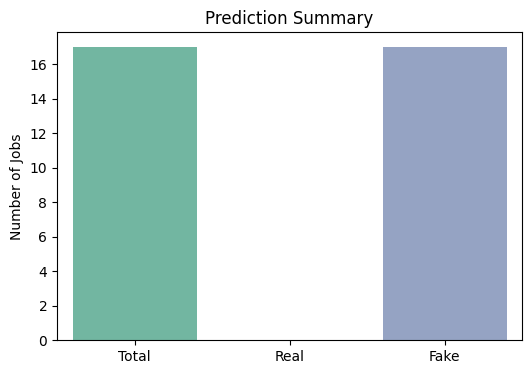

Saved real jobs to real_jobs.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
import re
import warnings
import io
warnings.filterwarnings("ignore")
nltk.download('stopwords')

from google.colab import files
print("Please upload the TRAINING dataset (must include: 'description' and 'fraudulent' columns):")
uploaded = files.upload()
file_name = next(iter(uploaded))
df = pd.read_csv(io.BytesIO(uploaded[file_name]), engine='python')

required_cols = {'description', 'fraudulent'}
if not required_cols.issubset(df.columns):
    raise ValueError(f"ERROR: The dataset must include the following columns: {required_cols}")


sns.countplot(x='fraudulent', data=df, palette='Set2')
plt.title("Real (0) vs Fake (1) Job Postings")
plt.xlabel("fraudulent")
plt.ylabel("count")
plt.show()

df['description_len'] = df['description'].fillna('').apply(lambda x: len(x.split()))
sns.histplot(data=df, x='description_len', hue='fraudulent', bins=40, kde=True)
plt.title("Job Description Length by Label")
plt.show()

stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return ' '.join([word for word in text.split() if word not in stop_words])

df['cleaned_text'] = df['description'].fillna('').apply(clean_text)

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

MAX_VOCAB = 12000
MAX_LEN = 120

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_text'])
X_seq = tokenizer.texts_to_sequences(df['cleaned_text'])
X_pad = pad_sequences(X_seq, maxlen=MAX_LEN, padding='post')

X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_pad, y, test_size=0.2, random_state=42)

lstm_model = Sequential([
    Embedding(MAX_VOCAB, 128, input_length=MAX_LEN),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_dl, y_train_dl, epochs=4, batch_size=256, validation_split=0.1)

loss, acc = lstm_model.evaluate(X_test_dl, y_test_dl)
print(f"\n LSTM Accuracy on Test Data: {acc:.4f}")

print("\n Upload TEST CSV file (must include 'description' column):")
uploaded = files.upload()
test_file = next(iter(uploaded))
input_df = pd.read_csv(io.BytesIO(uploaded[test_file]))

if 'description' not in input_df.columns:
    raise ValueError("ERROR: Uploaded test file must include a 'description' column.")

input_df['cleaned_text'] = input_df['description'].fillna('').apply(clean_text)
X_input_seq = tokenizer.texts_to_sequences(input_df['cleaned_text'])
X_input_pad = pad_sequences(X_input_seq, maxlen=MAX_LEN, padding='post')

preds = lstm_model.predict(X_input_pad).flatten()
labels = (preds > 0.5).astype(int)
confidences = np.abs(preds - 0.5) * 2 + 0.5

input_df['Prediction'] = labels
input_df['Confidence'] = confidences

total = len(input_df)
real = (labels == 0).sum()
fake = (labels == 1).sum()

print("\n PREDICTION SUMMARY")
print(f" Total jobs uploaded: {total}")
print(f" Real jobs detected: {real}")
print(f" Fake jobs detected: {fake}")

plt.figure(figsize=(6, 4))
sns.barplot(x=['Total', 'Real', 'Fake'], y=[total, real, fake], palette='Set2')
plt.title("Prediction Summary")
plt.ylabel("Number of Jobs")
plt.show()

if total == 1:
    job_type = "REAL" if labels[0] == 0 else "FAKE"
    print(f"\n This job is predicted to be {job_type} with {confidences[0]*100:.2f}% confidence.")
else:
    real_jobs = input_df[input_df['Prediction'] == 0]
    real_jobs.to_csv("real_jobs.csv", index=False)
    print("Saved real jobs to real_jobs.csv")

    # Download file
    files.download("real_jobs.csv")
